# Import necessary libraries

In [ ]:
import os, sys, pdb, tqdm
import numpy as np
import random

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# NLP related
import pandas as pd
import unicodedata, re, string
import nltk

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.autograd as autograd

# Show the same warnings only once
import warnings
warnings.filterwarnings(action='once')

torch.manual_seed(1)

# Install Kaggle library
!pip install -q kaggle
# Colab library to upload files to notebook
from google.colab import files
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


# 0. Data Exploration and Pre-processing

## Download and Read Files

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!mkdir ~/sentiment-analysis-on-movie-reivews

403 - Forbidden


In [ ]:
!pip show kaggle

Name: kaggle
Version: 1.5.12
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: requests, python-slugify, python-dateutil, tqdm, six, urllib3, certifi
Required-by: 


In [ ]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews -p sentiment-analysis-on-movie-reviews

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 33.7MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 86.5MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 81.4MB/s]


In [ ]:
DATA_ROOT = 'sentiment-analysis-on-movie-reviews/'
df_train = pd.read_csv(os.path.join(DATA_ROOT, 'train.tsv.zip'), sep="\t")
df_test = pd.read_csv(os.path.join(DATA_ROOT,'test.tsv.zip'), sep="\t")
print(df_train.shape,df_test.shape)
df_train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


## Data Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


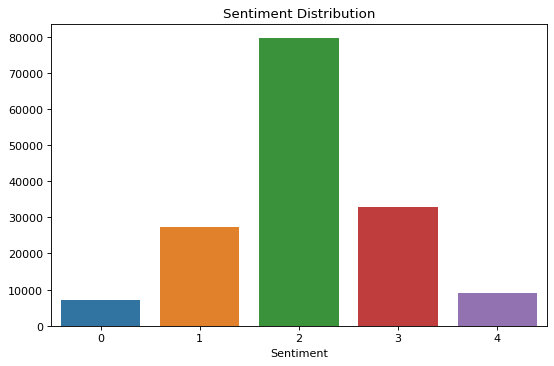

In [ ]:
dist = df_train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(8,5), dpi=80)
ax.set_title('Sentiment Distribution')
sns.barplot(dist.keys(), dist.values);

## Data Pre-processing

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with
    textual representation
    """
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words 
    (ate => eat, cars => car, ...)
    """
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    """Execute all the pre-processing steps"""
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    # words = remove_stopwords(words)
    return words

<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence \d
<input>:32: DeprecationWarning: invalid escape sequence 

### Step 1: Tokenizing phrases

In [ ]:
# Step 0, we need to download the 'punkt' sentece tokenizer for nltk
nltk.download('punkt')

# Add another column 'Words' to store tokenized phrases
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Step 2: Passing through prep functions defined above

In [ ]:
df_train['Words'] = df_train['Words'].apply(normalize) 
df_train['Words'].head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Words, dtype: object

### Step 3: Creating a list of unique words to be used as dictionary for encoding

In [ ]:
word_set = set()
for l in df_train['Words']: # Loop through each phrase
    for e in l: # Loop through each word in each phrase
        word_set.add(e) # Add to the vocabulary

# Index of word starts from 1, 0 is reserved for padding
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}
# Check if they are still the same lenght
assert len(word_set) == len(word_to_int)
print("Size of vocabulary: {}".format(len(word_set)))

Size of vocabulary: 16209


In [ ]:
# Tokenize each phrase
# The phrases are represented as a list of numerical indices
df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'].head()

0    [8918, 9185, 15397, 13572, 11528, 5354, 9286, ...
1    [8918, 9185, 15397, 13572, 11528, 5354, 9286, ...
2                                         [8918, 9185]
3                                               [8918]
4                                               [9185]
Name: Tokens, dtype: object

### Step 4: Pad each phrase representation with zeroes, starting from the beginning of sequence

In [ ]:
# Get the length of longest phrase for padding
max_len = df_train['Tokens'].str.len().max()
print("The length of longest phrase: {}".format(max_len))

# Will use a combined list of phrases as np array for further work. 
# This is expected format for the Pytorch utils to be used later.
all_tokens = np.array([t for t in df_train['Tokens']])
encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features = np.zeros((len(all_tokens), max_len), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#print first 3 rows of the feature matrix
print('\n')
print(features[:3])

The length of longest phrase: 48


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys




[[ 8918  9185 15397 13572 11528  5354  9286  4568 12311  6042  7884  5792
   5354  4474  6042  2567  7884  5792  5354 13551  9710 15397 11688 13372
   2719  2713 10511 15397 11688  4139  4855  1000 15397  8918 12197     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 8918  9185 15397 13572 11528  5354  9286  4568 12311  6042  7884  5792
   5354  4474     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 8918  9185     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


### Step 5: Split the data into training, validation, and test data

In [ ]:
# <split_frac> of the data as training set
# (1 - <split_frac>) / 2 of the data as validation set
# (1 - <split_frac>) / 2 of the data as test set

split_frac = 0.8

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
valid_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
valid_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(valid_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(124848, 48) 
Validation set: 	(15606, 48) 
Test set: 		(15606, 48)


# 1. Defining PyTorch DataLoader and Using Word2Vec

In [ ]:
# Embedders requires Long-type inputs
train_data = TensorDataset(torch.tensor(train_x), \
                           torch.tensor(train_y.astype(np.long)))
valid_data = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))
test_data = TensorDataset(torch.tensor(test_x), torch.tensor(test_y))

batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
# How the embedder works
# Convert tokenized phrases into vectors (Word2Vec))
embeds = nn.Embedding(len(word_to_int), 5)  # words in vocab, 5 dimensional
lookup_tensor = torch.tensor([word_to_int["good"]], dtype=torch.long)
sample_embed = embeds(lookup_tensor)
print(sample_embed)

tensor([[-0.2254,  0.1823, -1.5227, -2.2427, -1.2934]],
       grad_fn=<EmbeddingBackward0>)


# 2. Defining LSTM Model

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """Initialize the model by setting up the layers."""
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_size)
        
        # Softmax
        self.softmax = nn.LogSoftmax()
        # self.softmax = nn.Softmax()
        
        # Train on GPU or CPU
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        
    def forward(self, x, hidden):
        """Perform a forward pass of our model on some input and hidden state."""
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(torch.tensor(x, dtype=torch.long, device=self.device))

        lstm_out, hidden = self.lstm(embeds, hidden)

        # transform lstm output to input size of linear layers
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden
    
    def init_hidden(self, batch_size):
        """Initializes hidden state"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
              weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        
        return hidden

# 3. Instantiate The Model

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(word_to_int) + 1 # +1 for the 0 padding
output_size = 5 # One-hotted 5 targets
embedding_dim = 400 # Dimension of embedding vectors
hidden_dim = 256 # Number of hidden states
n_layers = 2 # Depth of LSTM

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

# 4. Train the Model

In [ ]:
print_every = 500
counter = 0
epochs = 4  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available:
    net.to(device)

net.train()
# Train for <epochs> iterations
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # Loop by batches
    for inputs, labels in train_loader:
        counter += 1

        # LSTM is sensitive to the batch size as initializing hidden states
        # depends on the batch size
        if inputs.shape[0] != batch_size:
            continue
        inputs, labels = inputs.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                if inputs.shape[0] != batch_size:
                    continue
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/4... Step: 500... Loss: 1.236791... Val Loss: 1.300895
Epoch: 1/4... Step: 1000... Loss: 1.171486... Val Loss: 1.207268
Epoch: 1/4... Step: 1500... Loss: 1.077616... Val Loss: 1.164791
Epoch: 2/4... Step: 2000... Loss: 1.079831... Val Loss: 1.116331
Epoch: 2/4... Step: 2500... Loss: 0.883917... Val Loss: 1.078987
Epoch: 2/4... Step: 3000... Loss: 0.939230... Val Loss: 1.068123
Epoch: 2/4... Step: 3500... Loss: 0.794756... Val Loss: 1.065902
Epoch: 3/4... Step: 4000... Loss: 0.790460... Val Loss: 1.110670
Epoch: 3/4... Step: 4500... Loss: 0.849094... Val Loss: 1.074749
Epoch: 3/4... Step: 5000... Loss: 0.706277... Val Loss: 1.067077
Epoch: 3/4... Step: 5500... Loss: 0.755363... Val Loss: 1.080955
Epoch: 4/4... Step: 6000... Loss: 0.522312... Val Loss: 1.095872
Epoch: 4/4... Step: 6500... Loss: 0.810623... Val Loss: 1.079469
Epoch: 4/4... Step: 7000... Loss: 0.694143... Val Loss: 1.091942
Epoch: 4/4... Step: 7500... Loss: 0.692285... Val Loss: 1.072772


# 5. Analysis on Test Set

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
test_preds = []
test_targets = []
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    if inputs.shape[0] != batch_size:
        continue
    
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    test_preds.append(pred.cpu().numpy())
    test_targets.append(labels.cpu().numpy())
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# Stack test predictions and targets
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 1.108
Test accuracy: 0.562


## Random Guess as Baseline

In [ ]:
# Randomly guess the sentiment score
correct = 0
for i, target in enumerate(test_y):
    if target == random.randint(0,4):
        correct += 1
print("Test random-guess accuracy: {:.3f}".format(correct / float(test_y.shape[0])))

Test random-guess accuracy: 0.205


## Confusion Matrix

In [ ]:
# Define a confusion matrix plotting function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


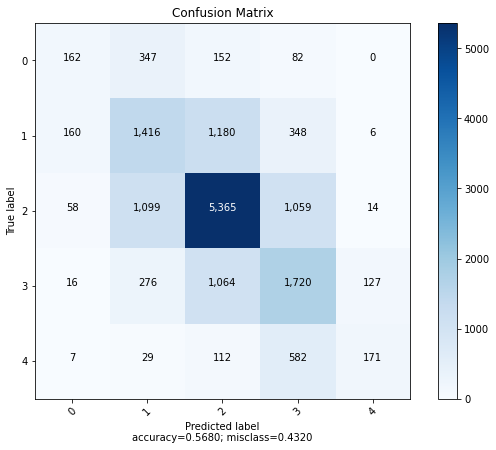

In [ ]:
cm = confusion_matrix(test_targets, test_preds, labels=[0, 1, 2, 3, 4])
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['0', '1', '2', '3', '4'],
                      title        = "Confusion Matrix")

# Reference
Sentiment Analysis: Rotten Tomato Movie Reviews: https://www.kaggle.com/oragula/sentiment-analysis-rotten-tomato-movie-reviews

torch.Size([5, 64, 256])
